<center><h1><b>DSTI</b></h1></center>
<center><h1><b>Machine Learning with Python Labs</b></h1></center>
<center><h3><b>BRUNET Nathan - AMOUSSOU KPAKPA Morell-Landry - GEDARA Lahiru Kosgahamula</b></h3></center></center>

# Automated Essay Scoring System

## Introduction
This project develops an Automated Essay Scoring (AES) system using a dataset of over 10,000 expert-graded essays. The goal is to build a machine learning model capable of assigning scores to essays with a degree of accuracy comparable to human expert graders.

## Data Preprocessing
The dataset was first loaded and then thoroughly cleaned. The cleaning steps included:
- Removal of entries with missing scores (`domain1_score`).
- Cleaning of essays

## Exploratory Data Analysis (EDA)
A comprehensive EDA was performed, with steps including:
- Heatmaps of missing data to identify  null values.
- Distribution analysis of essay scores.
- Examination of the average scores by essay set, highlighting the variation in grading across different topics.

## Feature Engineering
To enrich the model's input data, several feature engineering steps were conducted:
- Tokenization and removal of punctuation and stop words.
- Calculation of various text-based metrics such as average sentence length, readability scores (Flesch Reading Ease and Gunning Fog Index), and sentiment polarity.

## Model Selection and Training
For the modeling phase:
- A RandomForestRegressor was chosen for its robustness and effectiveness in handling diverse features.
- The model was trained on TF-IDF vectorized essay texts combined with the engineered features.
- Learning curves were plotted to visualize the model's performance over different sizes of training data.

## Evaluation Metrics
- The QWK (Quadratic Weighted Kappa) was the primary metric used for model evaluation, as it is specifically designed to measure agreement between two ratings, which is ideal for this grading task.
- Cross-validation scores were calculated to ensure the robustness and reliability of the model's performance.

## Conclusion
The AES system developed shows promising results in automating the essay grading process.

In [1]:
from files import *

## Exploratory Data Analysis

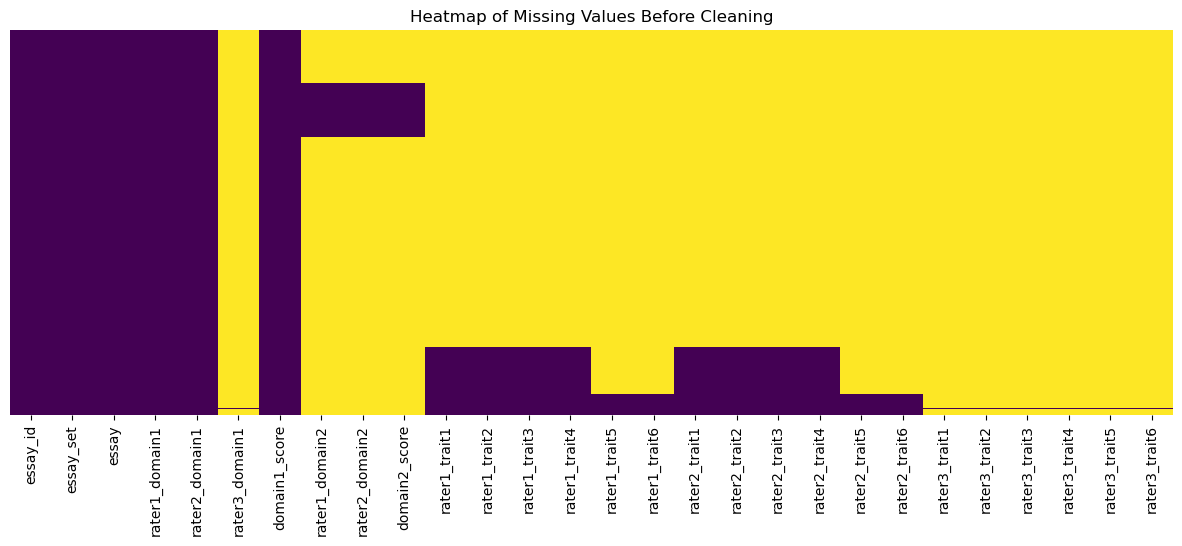

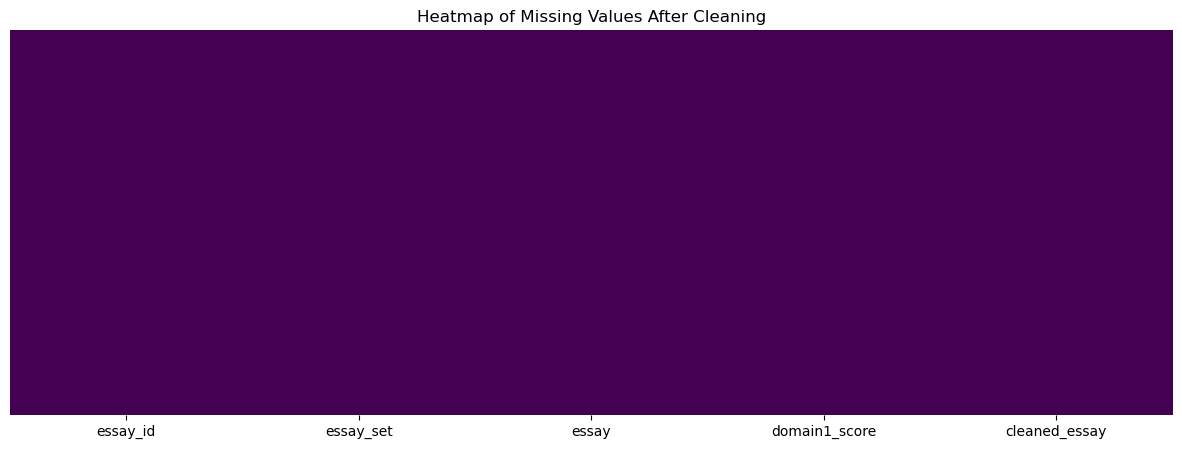

Columns remaining: ['essay_id', 'essay_set', 'essay', 'domain1_score', 'cleaned_essay']
Number of rows with non-missing 'domain1_score': 12977


In [2]:
# Load the dataset
train_df = pd.read_excel('training_set_rel3.xlsx')

# Make a copy of the DataFrame for modifications
train_df_cleaned = train_df.copy()

# Visualizing missing values before any operations
plt.figure(figsize=(15, 5))
sns.heatmap(train_df_cleaned.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of Missing Values Before Cleaning')
plt.show()

# Remove columns with missing values except for 'domain1_score' which contains the scores
cols_to_keep = train_df_cleaned.columns[train_df_cleaned.isna().sum() == 0].tolist() + ['domain1_score']
train_df_no_nans = train_df_cleaned[cols_to_keep]

# Drop rows where 'domain1_score' is NaN
train_df_no_nans = train_df_no_nans.dropna(subset=['domain1_score'])

# Clean the essays using the defined cleaning function
train_df_no_nans.loc[:, 'cleaned_essay'] = train_df_no_nans['essay'].apply(clean_essay_new)

# Visualizing missing values after cleaning
plt.figure(figsize=(15, 5))
sns.heatmap(train_df_no_nans.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of Missing Values After Cleaning')
plt.show()

# Displaying remaining columns and confirming 'domain1_score' is kept
print(f"Columns remaining: {train_df_no_nans.columns.tolist()}")
print(f"Number of rows with non-missing 'domain1_score': {train_df_no_nans['domain1_score'].notna().sum()}")

We choose to keep the columns essay_set, essay, rater2_domain1, rater2_domain1 et the variable to predict domain1_score. The dataset seems complete enough to perform modelling.

In [3]:
train_df_no_nans.head()

essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

   domain1_score                                      cleaned_essay  
0            8.0  dear local newspaper i think effects computers...  
1            9.0  dear   i believe that using computers will ben...  
2            7.0  dear    more and more people use computers but...  
3           10.0  dear local newspaper  i have found that many e...  
4            8.0  dear  i know having computers has a positive e...

Besides the essay and score columns, we have a column essay_set which seems to indicate which category each essay belongs to.

In [4]:
train_df_no_nans['essay_set'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

Given that we have distinct categories, it is appropriate to understand in more detail this variable on which we will base our predictions. Let's now analyze the distribution of our target variable.

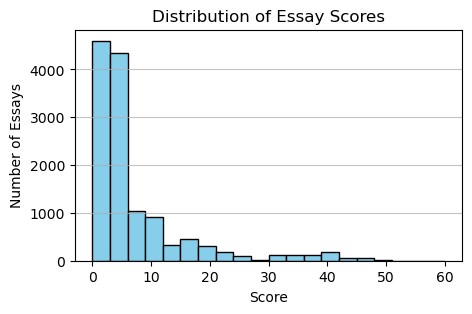

In [5]:
plt.figure(figsize=(5, 3))
plt.hist(train_df_no_nans['domain1_score'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Essay Scores')
plt.xlabel('Score')
plt.ylabel('Number of Essays')
plt.grid(axis='y', alpha=0.75)
plt.show()

The majority of scores seem to be between 0 and 20, and there is an imbalance that should be taken into account in the scoring.

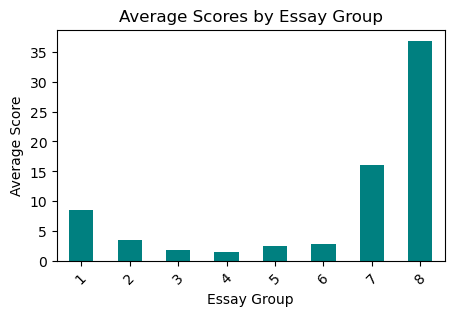

In [6]:
# Calculate average scores per essay group
scores_moyens_par_groupe = train_df_no_nans.groupby('essay_set')['domain1_score'].mean()
plt.figure(figsize=(5, 3))
scores_moyens_par_groupe.plot(kind='bar', color='teal')
plt.title('Average Scores by Essay Group')
plt.xlabel('Essay Group')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()

The average score varies significantly from one group to another, for example group 8 obtains higher scores compared to the rest of the groups.

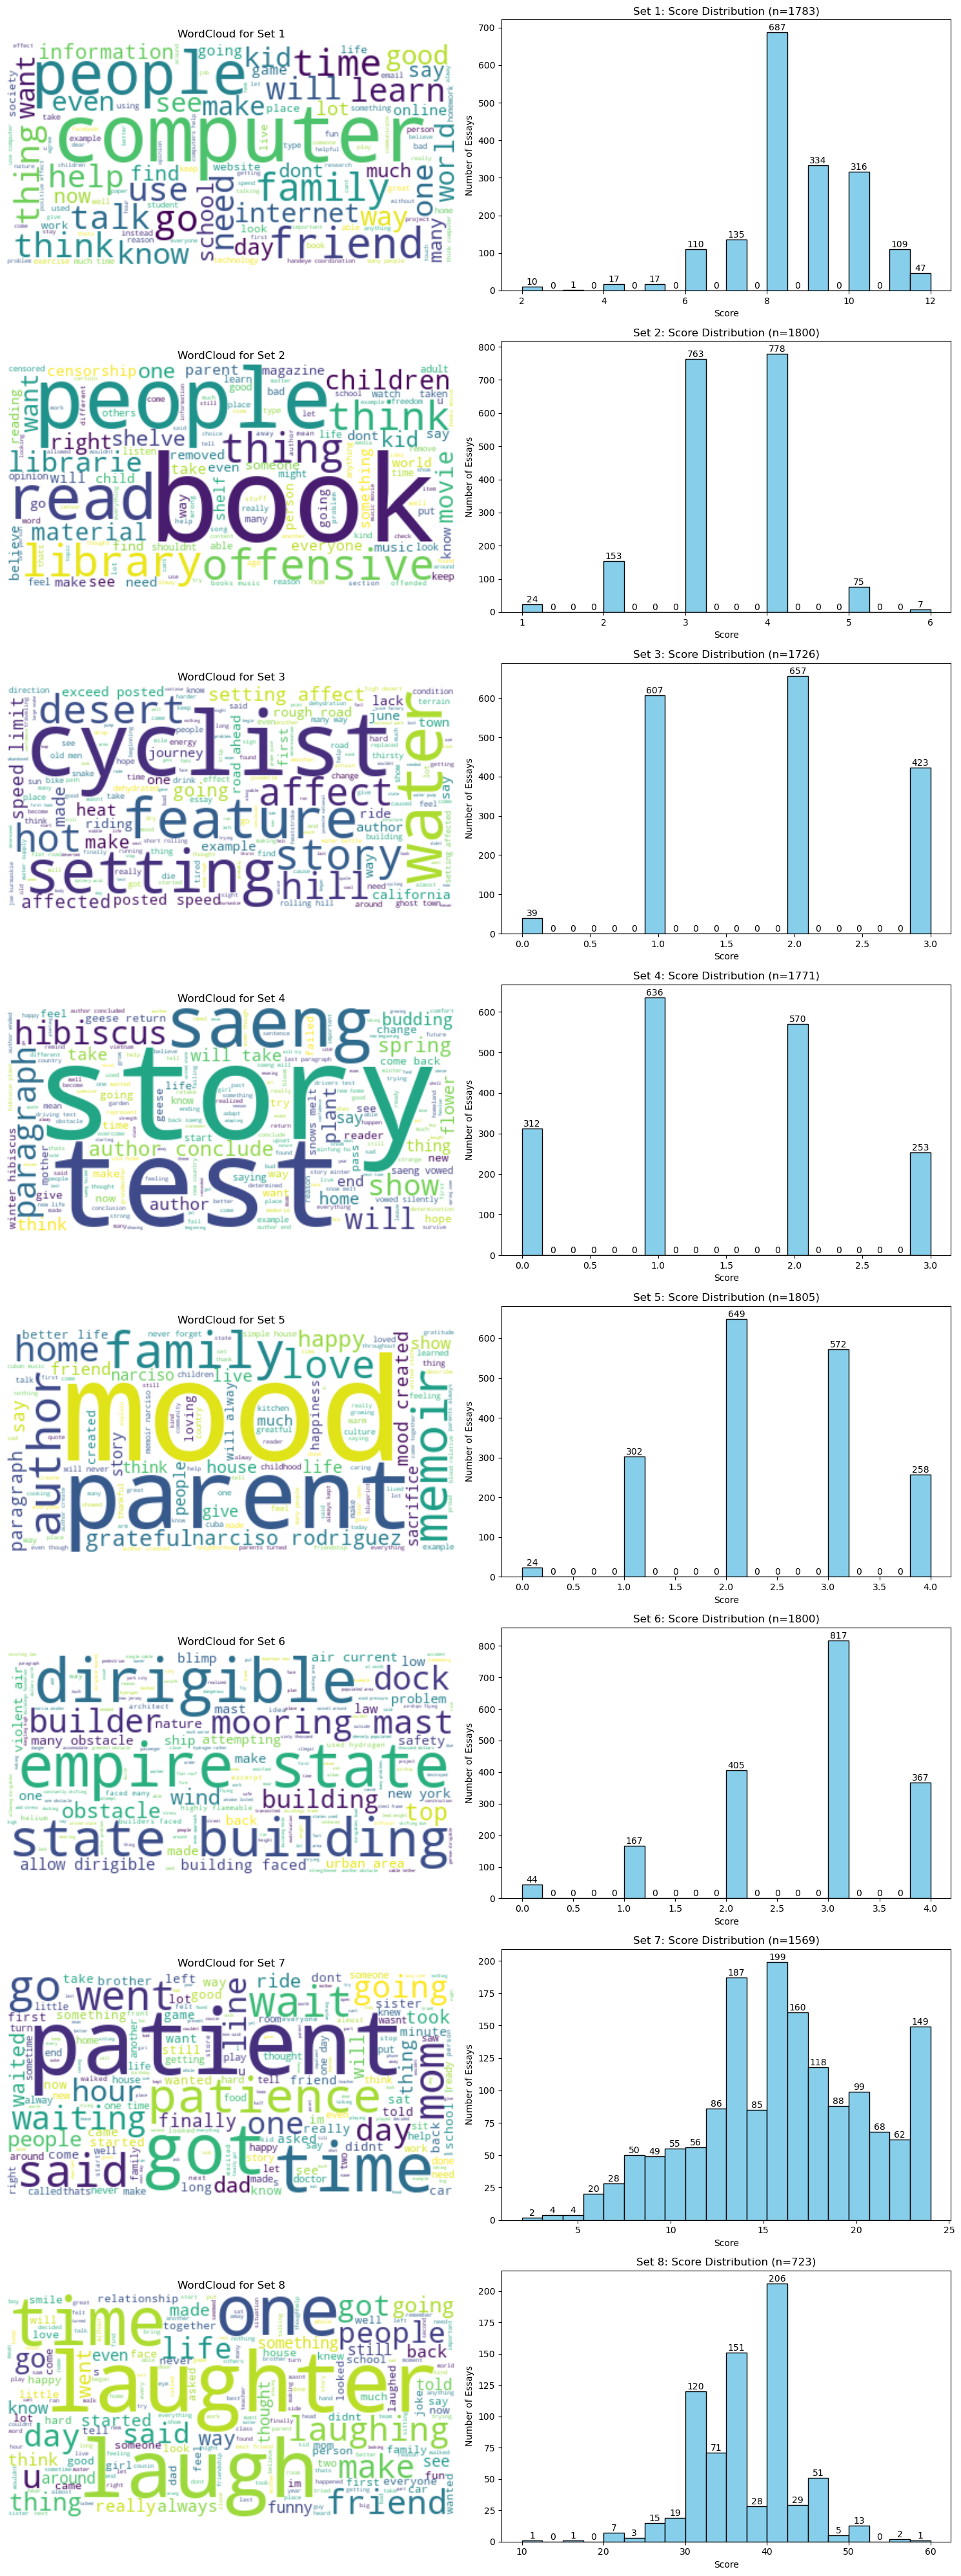

In [7]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 40)) 

# Iterate over each essay set and generate plots for each.
for i, essay_set in enumerate(sorted(train_df_no_nans['essay_set'].unique()), start=0):
    subset = train_df_no_nans[train_df_no_nans['essay_set'] == essay_set]
    
    # Generate a WordCloud for each essay set.
    topic_essays = subset['cleaned_essay']
    all_text = ' '.join(topic_essays)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(all_text)
    axes[i, 0].imshow(wordcloud, interpolation='bilinear')  # Changement des indices ici
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'WordCloud for Set {essay_set}')
    
    # Plot the score distribution for each essay set.
    counts, bins, patches = axes[i, 1].hist(subset['domain1_score'].dropna(), bins=20, color='skyblue', edgecolor='black')  # Changement des indices ici
    axes[i, 1].set_title(f'Set {essay_set}: Score Distribution')
    axes[i, 1].set_xlabel('Score')
    axes[i, 1].set_ylabel('Number of Essays')

    # Annotate each bar in the histogram with the count of essays it represents.
    for count, patch in zip(counts, patches):
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        axes[i, 1].annotate(str(int(count)), (x, y), ha='center', va='bottom')

    # Update the plot title to include the total number of essays in the essay set.
    total_essays = len(subset)
    axes[i, 1].set_title(f'Set {essay_set}: Score Distribution (n={total_essays})')
# Adjust the layout and display the plot.
plt.tight_layout()
plt.show()

We get an idea here of the potential theme present in one of the 8 groups, given the associated lexical field, as well as the distribution of scores, which varies considerably from one group to another. The variable 'n' gives us an indication of the number of data points present in each of the groups. It's worth noting that group 8 has a smaller number of data points compared to the others.

## Feature engineering

In [8]:
tokenizer = RegexpTokenizer(r'\w+')
english_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_essay(text):
    # Tokenize and remove punctuation for necessary metrics
    tokenized_with_punctuation = word_tokenize(text)

    # Calculate metrics that require punctuation and stop words
    ttr = calculate_ttr(text)
    avg_sentence_length = calculate_avg_sentence_length(text)
    guiraud_index = calculate_guiraud_index(text)
    sentiment_polarity = calculate_sentiment(text)
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)

    # Continue with Preprocessing: remove stop words and punctuation
    tokenized_without_punctuation = tokenizer.tokenize(text)
    tokens_without_stopwords = [word for word in tokenized_without_punctuation if word not in english_stopwords]
    lemmatized_tokens = [lemmatizer.lemmatize(stemmer.stem(token)) for token in tokens_without_stopwords]
    preprocessed_text = ' '.join(lemmatized_tokens)

    return {
        'preprocessed_essay': preprocessed_text,
        'ttr': ttr,
        'avg_sentence_length': avg_sentence_length,
        'guiraud_index': guiraud_index,
        'sentiment_polarity': sentiment_polarity,
        'flesch_reading_ease': flesch_reading_ease,
        'gunning_fog': gunning_fog,
    }

# Apply the preprocess_essay function to each cleaned essay
preprocessed_results = train_df_no_nans['cleaned_essay'].apply(preprocess_essay)

# Convert results to DataFrame, keeping same essay order
preprocessed_df = preprocessed_results.apply(pd.Series)

# Join new DataFrame with the original DataFrame on the index
train_df_no_nans = pd.concat([train_df_no_nans, preprocessed_df], axis=1)

In [9]:
train_df_no_nans.head()

essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

   domain1_score                                      cleaned_essay  \
0            8.0  dear local newspaper i think effects computers...   
1            9.0  dear   i believe that using computers will ben...   
2            7.0  dear    more and more people use computers but...   
3           10.0  dear local newspaper  i have found that many e...   
4            8.0  dear  i know having computers has a positive e...   

                                  preprocessed_essay       ttr  \
0  dear local newspap think effect comput peopl g...  0.483483   
1  dear believ use comput benefit u mani way like...  0.454768   
2  dear peopl use comput everyon agre benefit soc...  0.522059   
3  dear local newspap found mani expert say compu...  0.466942   
4  dear know comput posit effect peopl comput con...  0.425163   

   avg_sentence_length  guiraud_index  sentiment_polarity  \
0                333.0       8.822746            0.295840   
1                409.0       9.197108            0.274000   
2                272.0       8.610015            0.340393   
3                484.0      10.272727            0.260746   
4                461.0       9.128630            0.199684   

   flesch_reading_ease  gunning_fog  
0              -241.15       134.52  
1              -326.75       165.16  
2              -187.69       111.01  
3              -411.33       196.49  
4              -379.53       186.14

Displayed here is the dataframe containing the pre-processed text to which we have added new variables providing insights into the text, with the aim of giving more information to our model to make predictions.

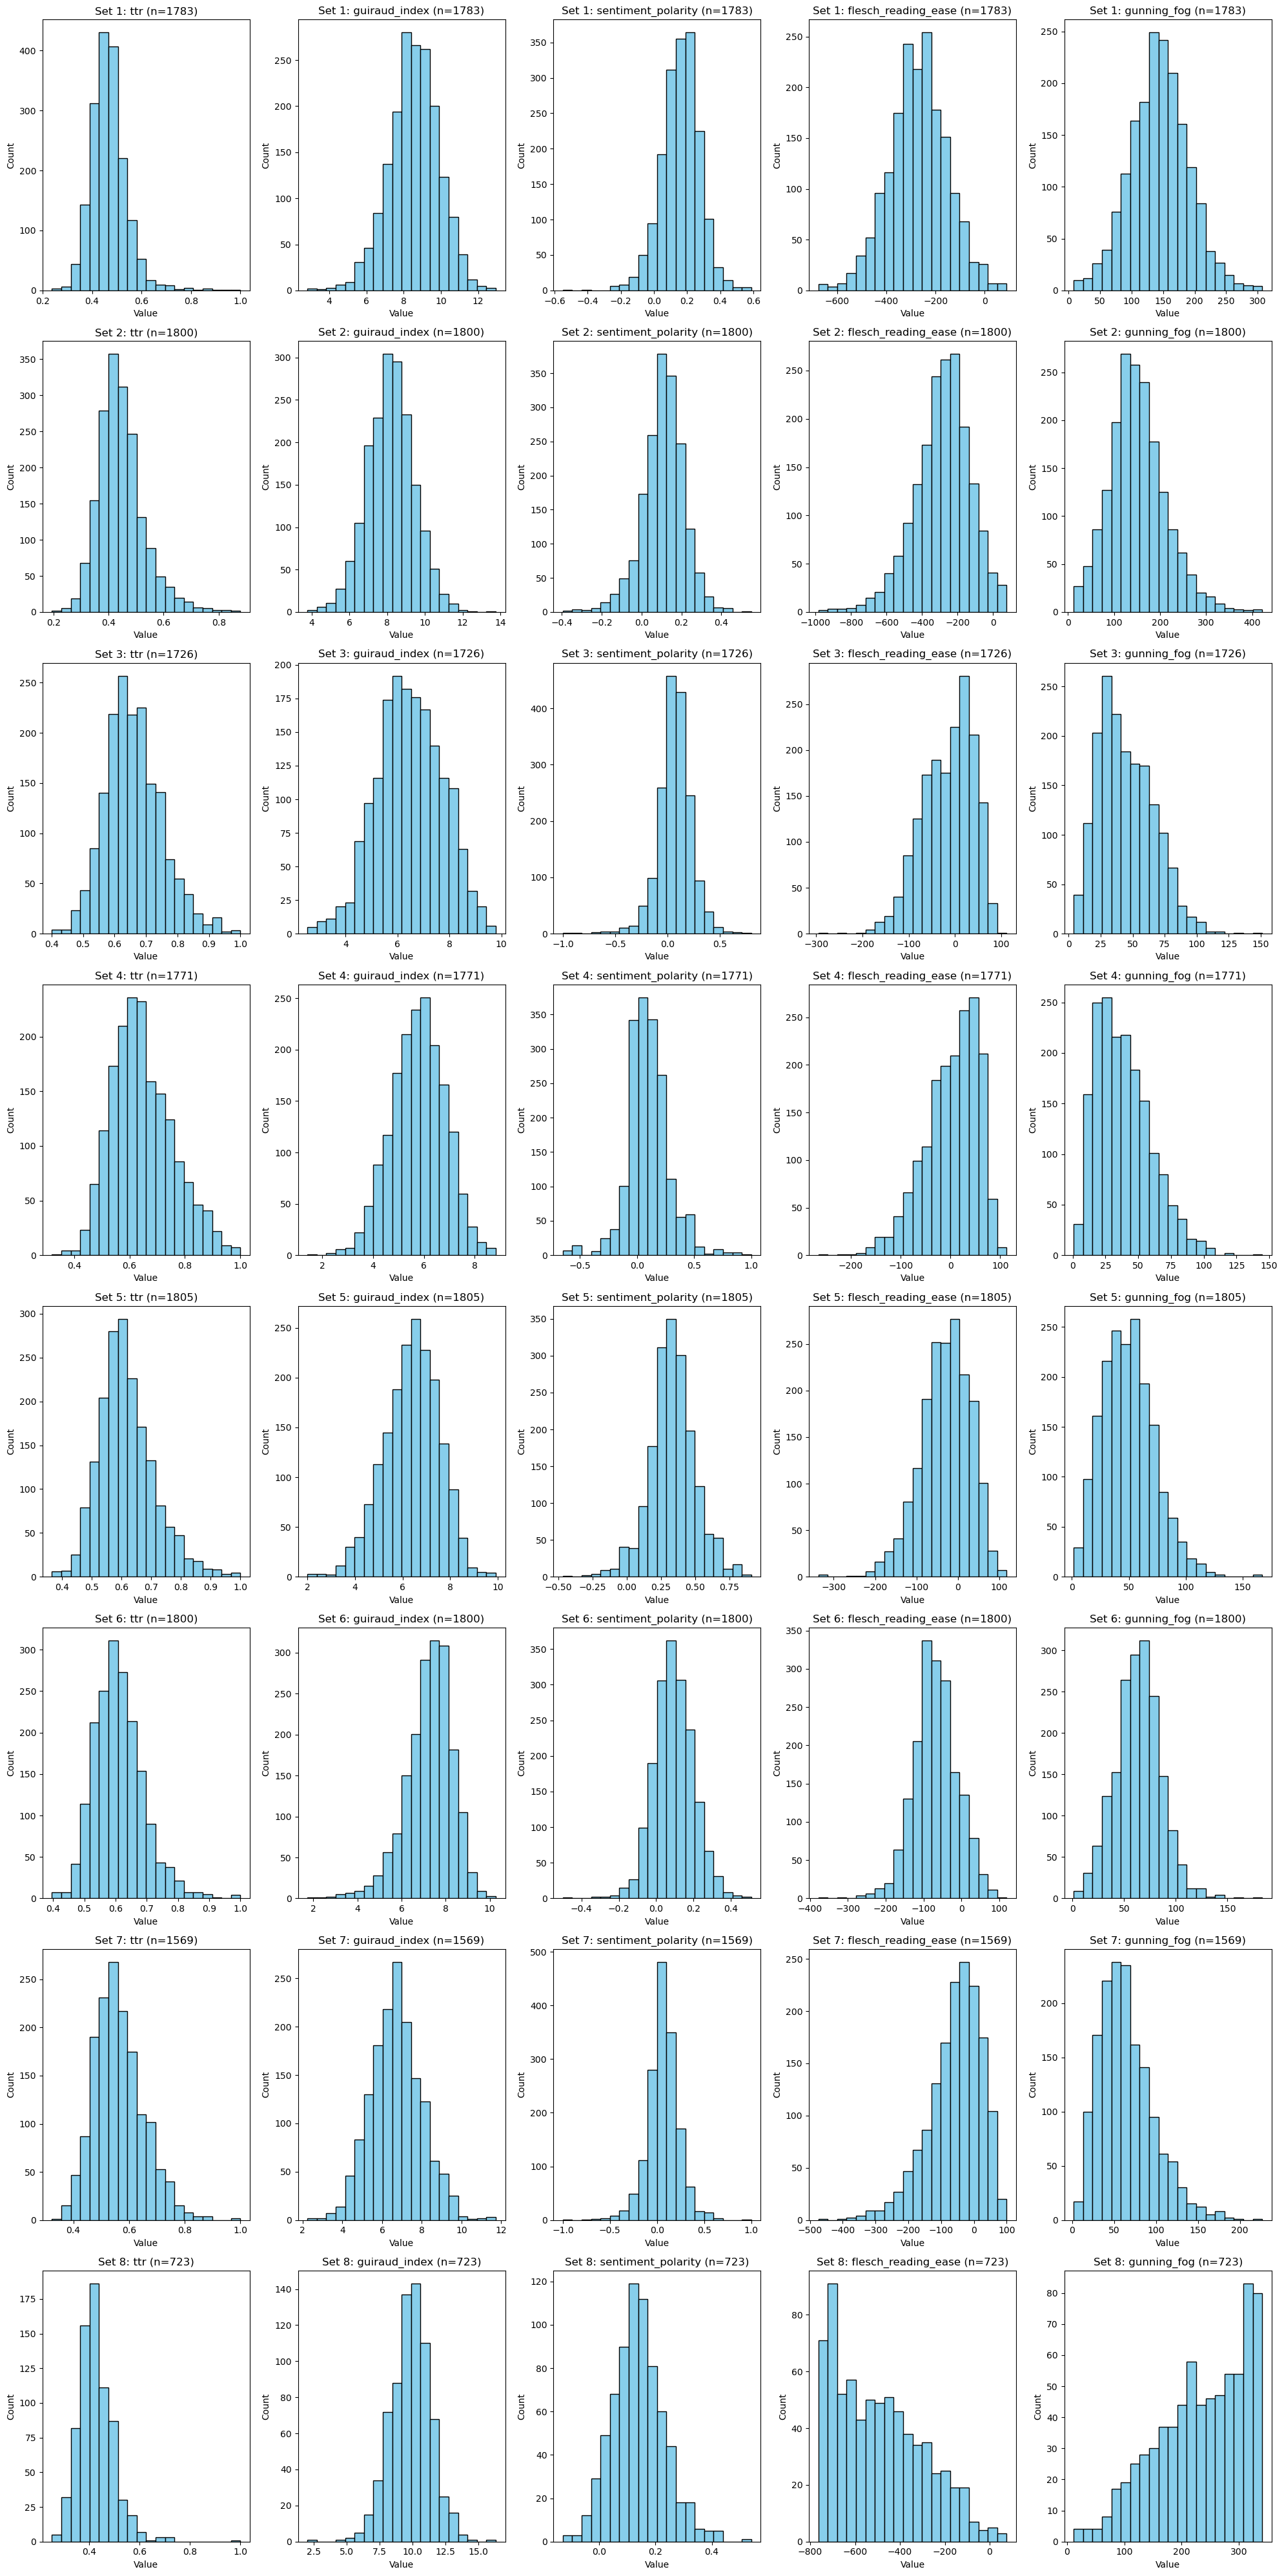

In [10]:
features = ['ttr', 'guiraud_index', 'sentiment_polarity',
            'flesch_reading_ease', 'gunning_fog']

essay_sets = sorted(train_df_no_nans['essay_set'].unique())
# Create subplots: one row for each 'essay_set' and one column for each variable
fig, axes = plt.subplots(nrows=len(essay_sets), ncols=len(features), figsize=(20, 40))

# Ensure that 'axes' is a 2D array even if 'essay_sets' or 'features' is of size 1
if len(essay_sets) == 1 or len(features) == 1:
    axes = np.array(axes).reshape(len(essay_sets), len(features))

# Loop over each essay group to create histograms
for i, es in enumerate(essay_sets):
    for j, feature in enumerate(features):
        # Select the current subplot's axis
        ax = axes[i, j] if len(essay_sets) > 1 else axes[j]
        # Select the data for the current feature
        data = train_df_no_nans[train_df_no_nans['essay_set'] == es][feature].dropna()
        # Check that we have a proper Series
        if isinstance(data, pd.Series):
            # Create the histogram for the current feature
            ax.hist(data, bins=20, color='skyblue', edgecolor='black')
            ax.set_title(f'Set {es}: {feature} (n={len(data)})')
            ax.set_xlabel('Value')
            ax.set_ylabel('Count')
        else:
            ax.text(0.5, 0.5, 'Data Error', horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes)

plt.tight_layout()
plt.show()

Each line corresponds to a group, from number 1 to number 8. We look at the distribution of all the indicators created within the different groups to analyze the different metrics. For example, we can note that the sentence length of group 8 is higher than for the other groups.

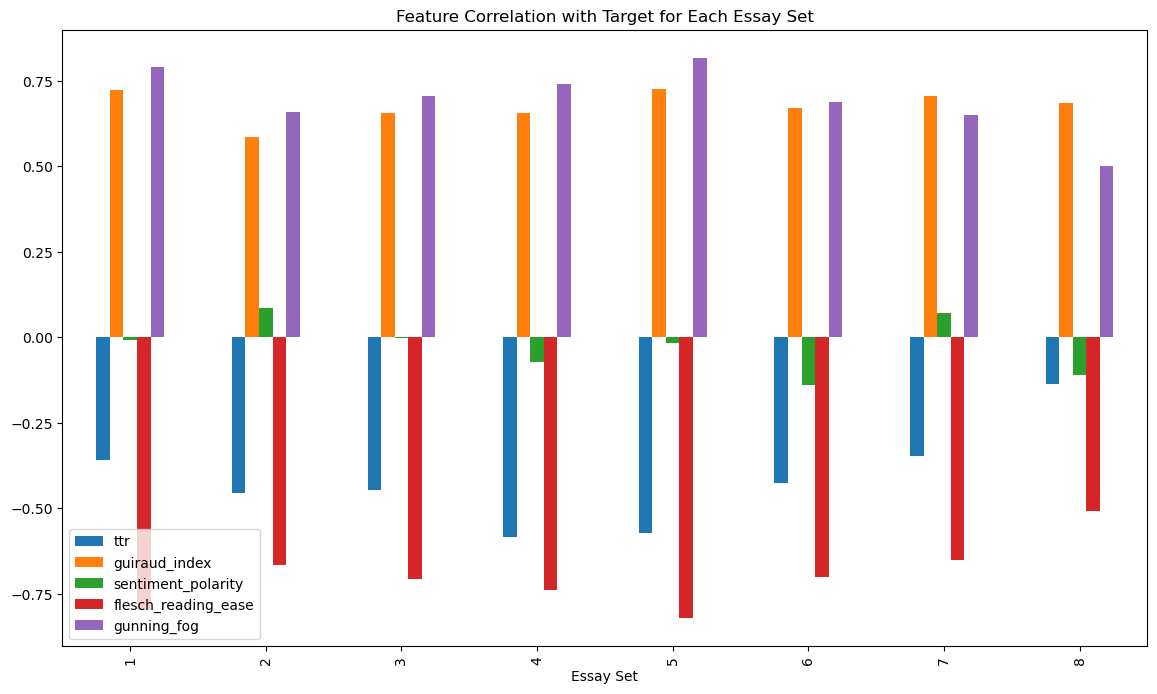

In [11]:
features = ['ttr', 'guiraud_index', 'sentiment_polarity',
            'flesch_reading_ease', 'gunning_fog']

essay_sets = train_df_no_nans['essay_set'].unique()

# Initialize a list to store correlation data for each essay set
correlation_data = []

# Loop over each essay set to calculate feature correlations with the target score
for es in essay_sets:
    # Select the subset of data for the current essay set
    subset = train_df_no_nans[train_df_no_nans['essay_set'] == es]
    # Compute correlations of features with the target score and drop the target score itself
    corr_with_target = subset[features + ['domain1_score']].corr()['domain1_score'].drop('domain1_score')
    # Append the correlation data to our list
    correlation_data.append(corr_with_target)

# Convert the list of correlation data into a DataFrame
correlation_df = pd.DataFrame(correlation_data, index=essay_sets)

# Plot the correlation data using bar charts
correlation_df.plot(kind='bar', figsize=(14, 8))
plt.title('Feature Correlation with Target for Each Essay Set')
plt.xlabel('Essay Set')
plt.show()  # Display the plot


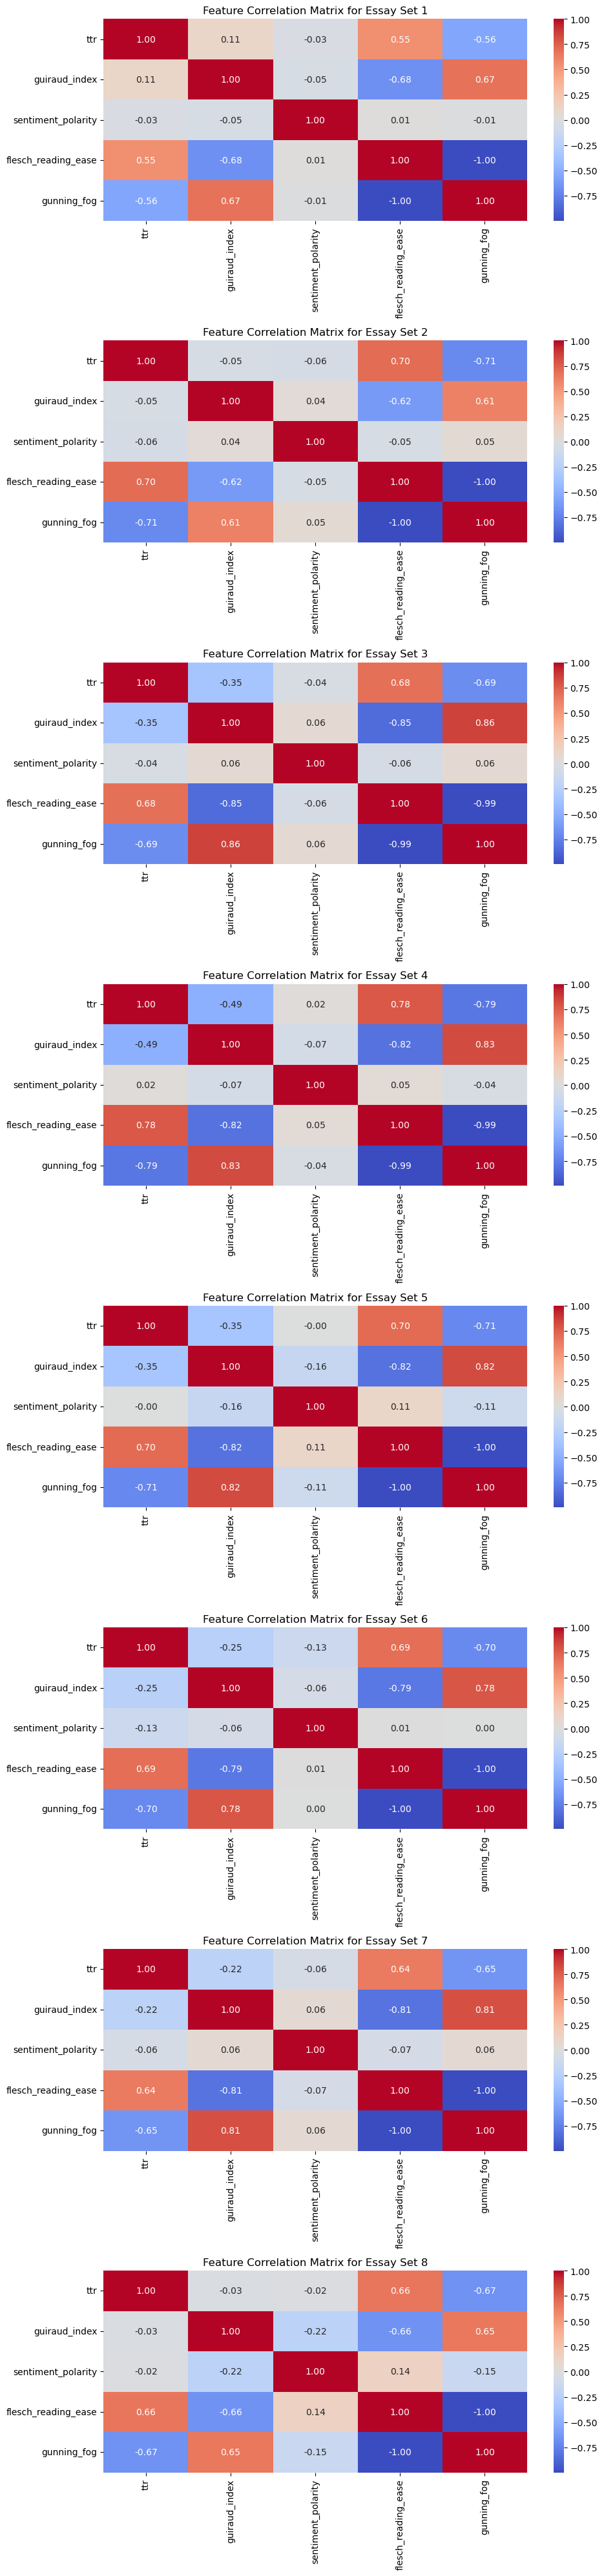

In [12]:
# Define the text features for which we want to compute correlations
features = ['ttr', 'guiraud_index', 'sentiment_polarity',
            'flesch_reading_ease', 'gunning_fog']

# Retrieve unique sets of essays
essay_sets = train_df_no_nans['essay_set'].unique()

# Initialize the figure with a subplot for each essay set
fig, axes = plt.subplots(nrows=len(essay_sets), ncols=1, figsize=(10, 5 * len(essay_sets)))

# If there is only one essay set, we make sure 'axes' is iterable by wrapping it in a list
if len(essay_sets) == 1:
    axes = [axes]

# Loop through each essay set to plot the correlation matrix for the features
for ax, es in zip(axes, essay_sets):
    # Select the subset of DataFrame corresponding to the current essay set
    subset = train_df_no_nans[train_df_no_nans['essay_set'] == es]
    
    # Compute the correlation matrix for the features (not including the target score)
    corr_matrix = subset[features].corr()
    
    # Create a heatmap from the correlation matrix and place it in the current subplot
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
    
    # Set the title for the subplot to indicate the essay set number
    ax.set_title(f'Feature Correlation Matrix for Essay Set {es}')

# Adjust the layout of the plot to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the heatmap plot
plt.show()

## Modeling

In [13]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))
    
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=qwk_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.1)
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.1)
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.legend(loc="best")

    return plt

<Figure size 640x480 with 0 Axes>

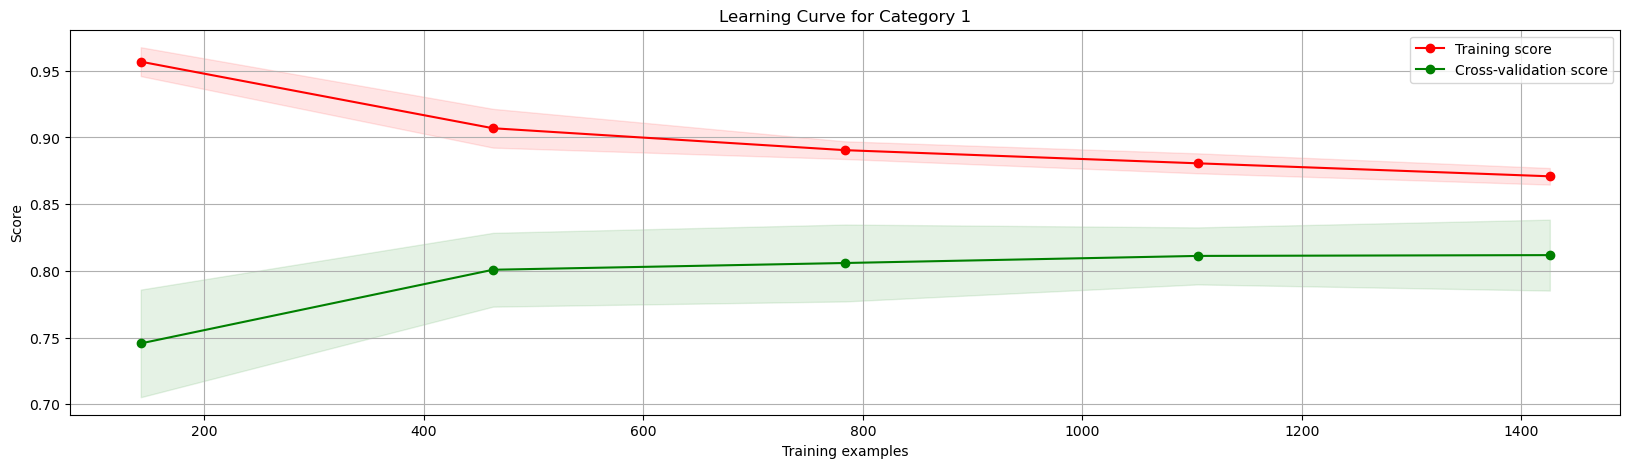

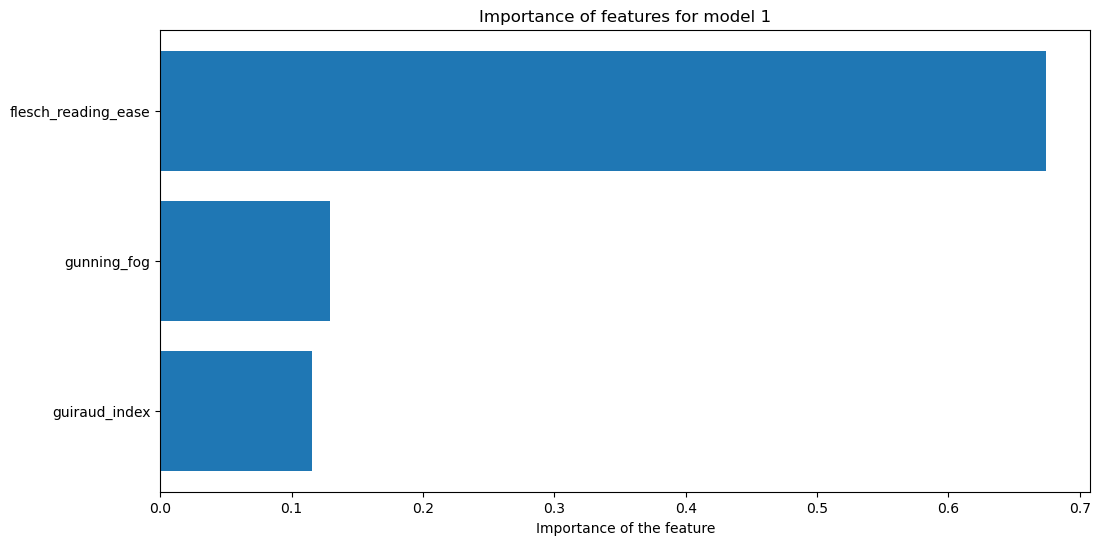

Category 1 - QWK scores for each fold: [0.84360577 0.79768285 0.81608955 0.77119295 0.83299587]
Category 1 - Average QWK: 0.8123133983086414
Category 1 - Standard Deviation of QWK: 0.025792171729934164


<Figure size 640x480 with 0 Axes>

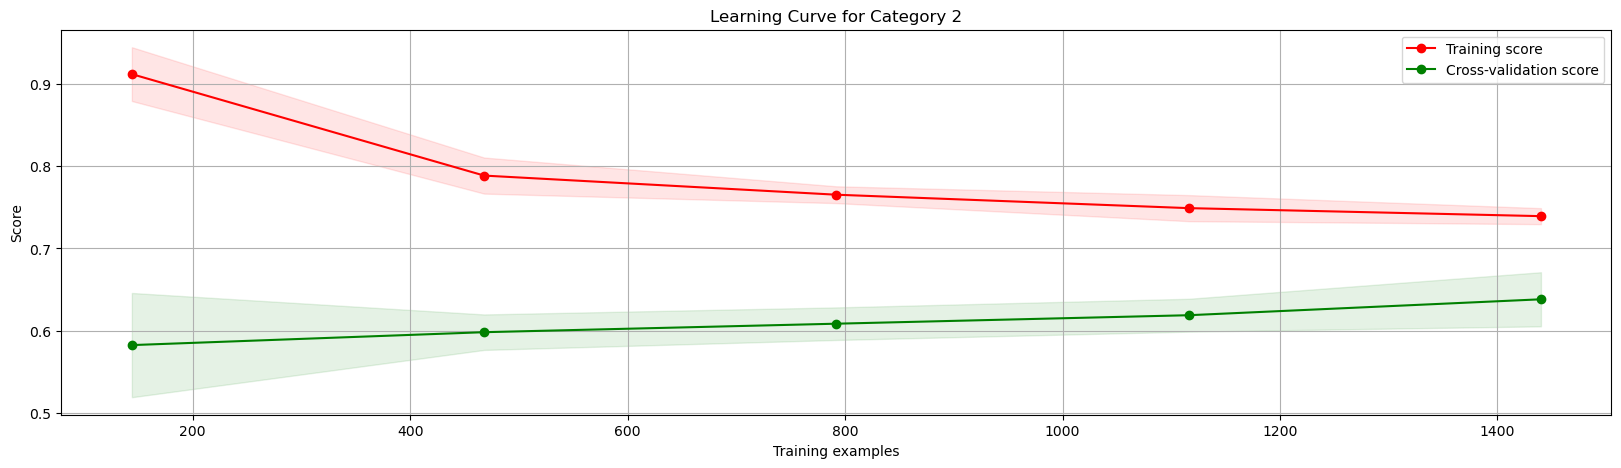

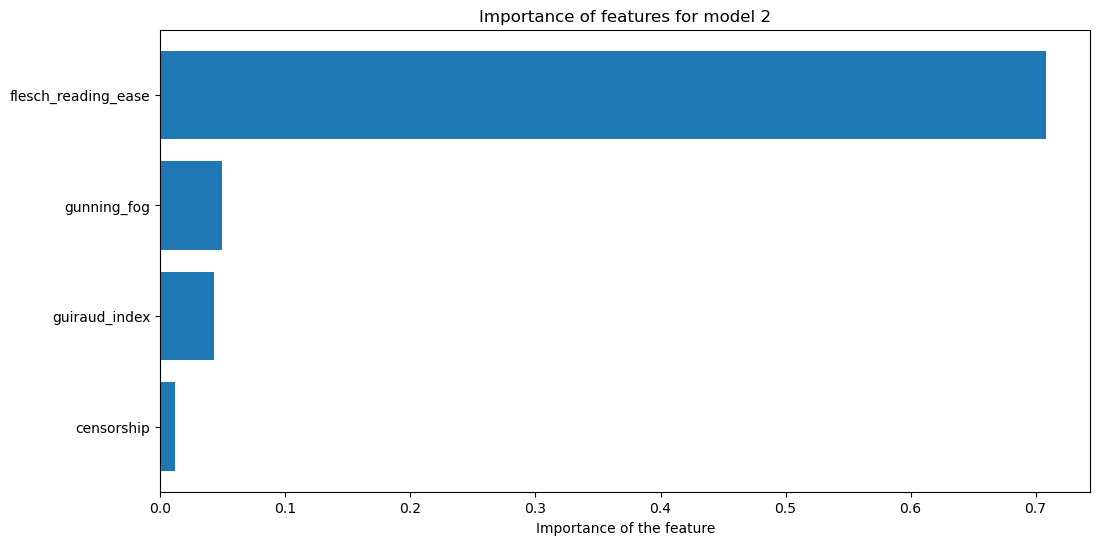

Category 2 - QWK scores for each fold: [0.63333333 0.58430233 0.63067381 0.65965311 0.68269564]
Category 2 - Average QWK: 0.6381316446677081
Category 2 - Standard Deviation of QWK: 0.0329404377251994


<Figure size 640x480 with 0 Axes>

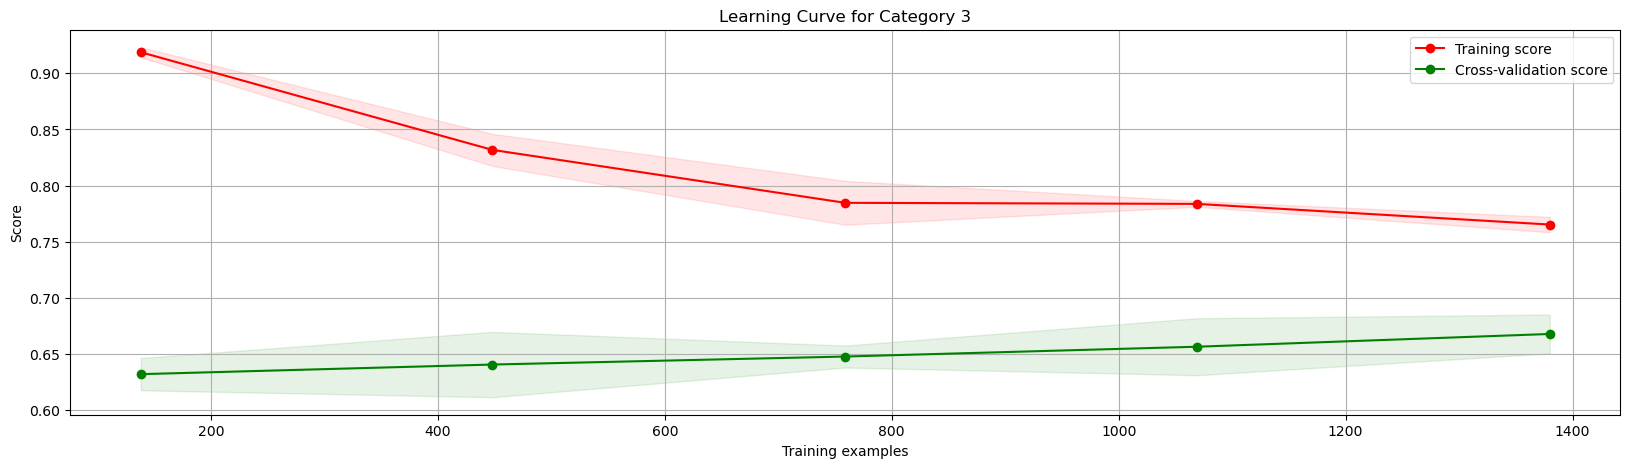

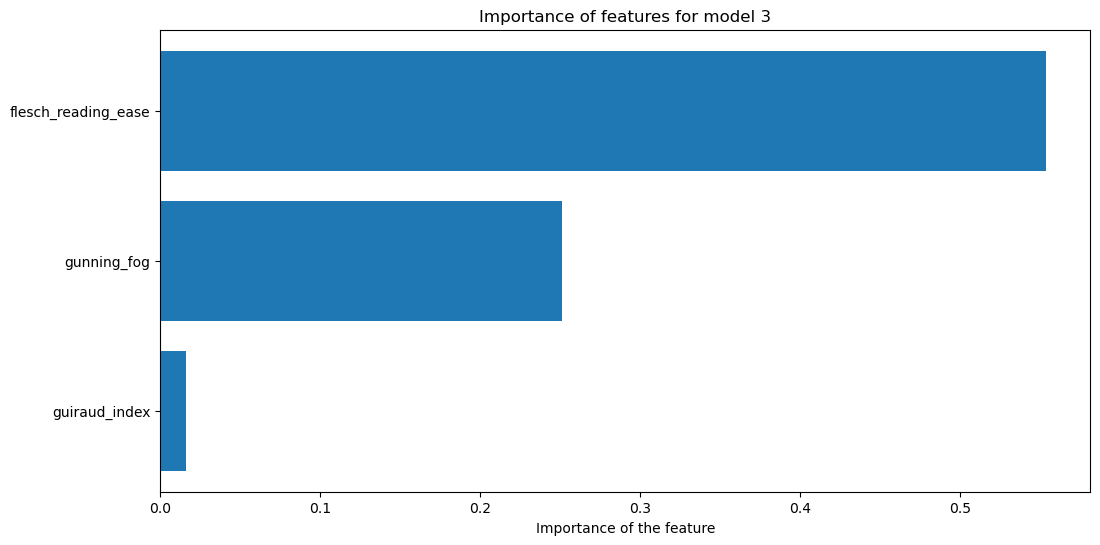

Category 3 - QWK scores for each fold: [0.64514736 0.65084315 0.69613787 0.6562866  0.68436348]
Category 3 - Average QWK: 0.6665556914990061
Category 3 - Standard Deviation of QWK: 0.020014381872871613


<Figure size 640x480 with 0 Axes>

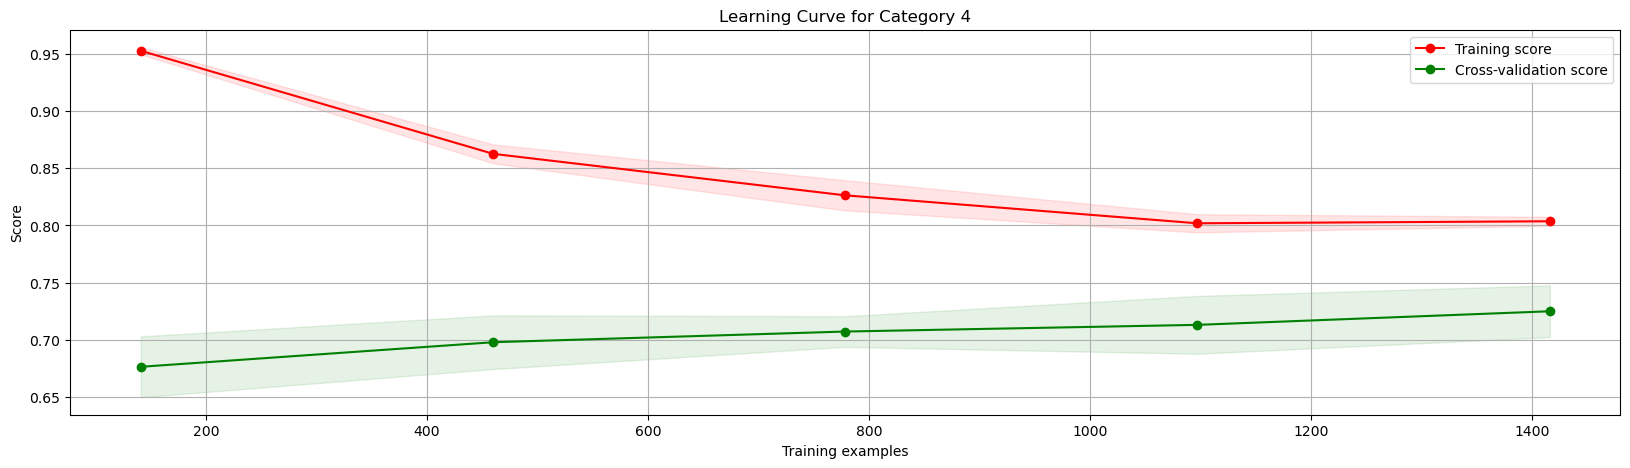

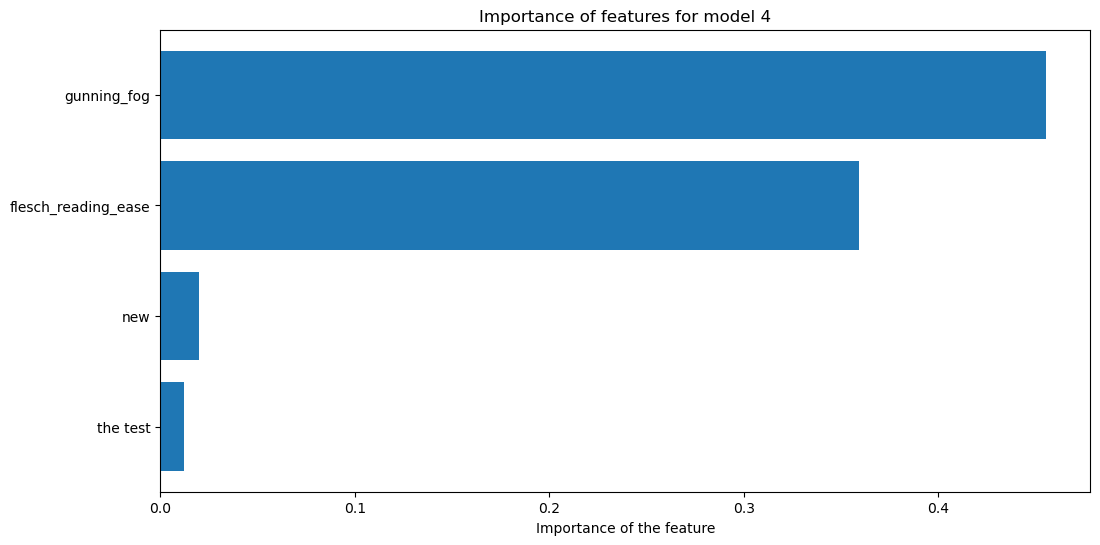

Category 4 - QWK scores for each fold: [0.72914366 0.74029612 0.68401459 0.71949843 0.74917959]
Category 4 - Average QWK: 0.7244264769532515
Category 4 - Standard Deviation of QWK: 0.022557574033524923


<Figure size 640x480 with 0 Axes>

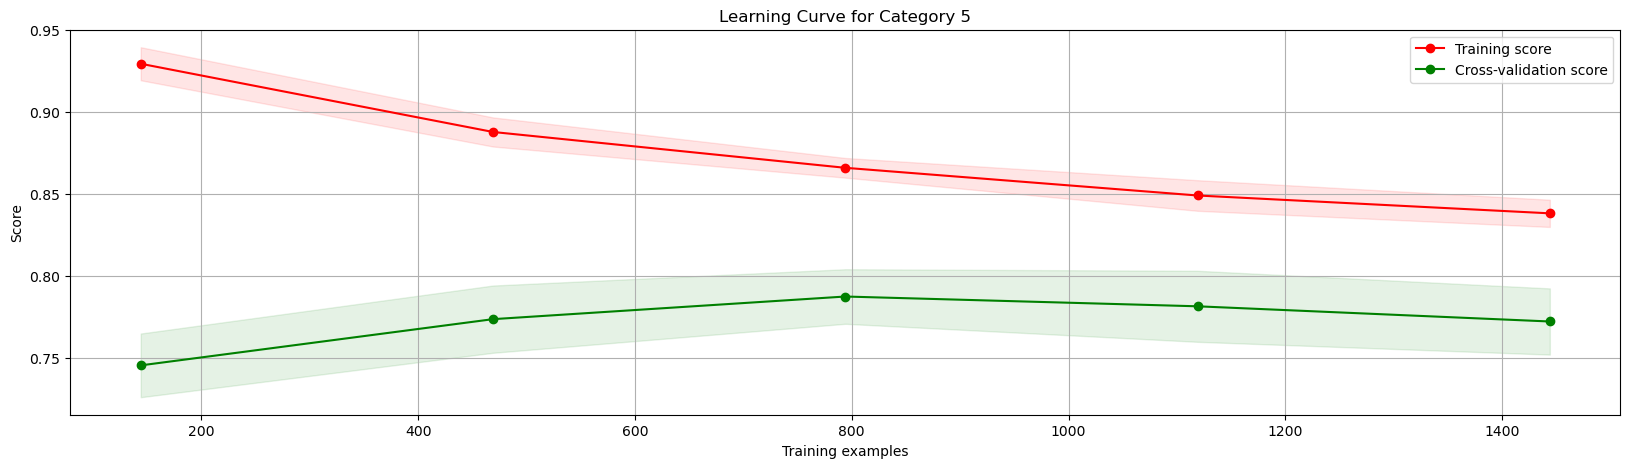

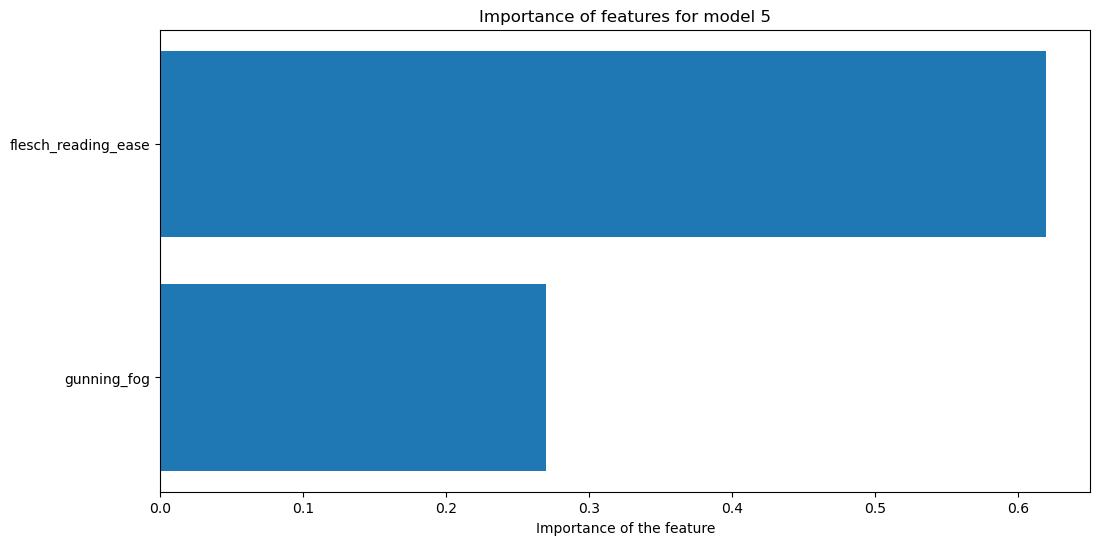

Category 5 - QWK scores for each fold: [0.7618688  0.75520777 0.76036799 0.81107499 0.77181006]
Category 5 - Average QWK: 0.772065919046619
Category 5 - Standard Deviation of QWK: 0.020232611830934347


<Figure size 640x480 with 0 Axes>

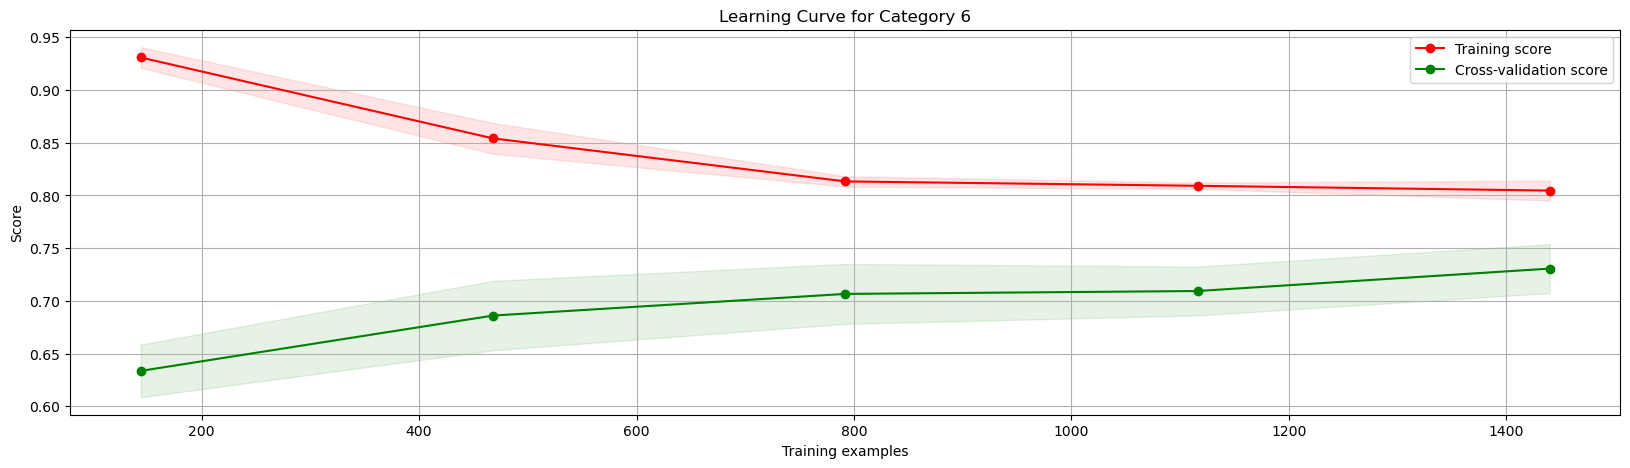

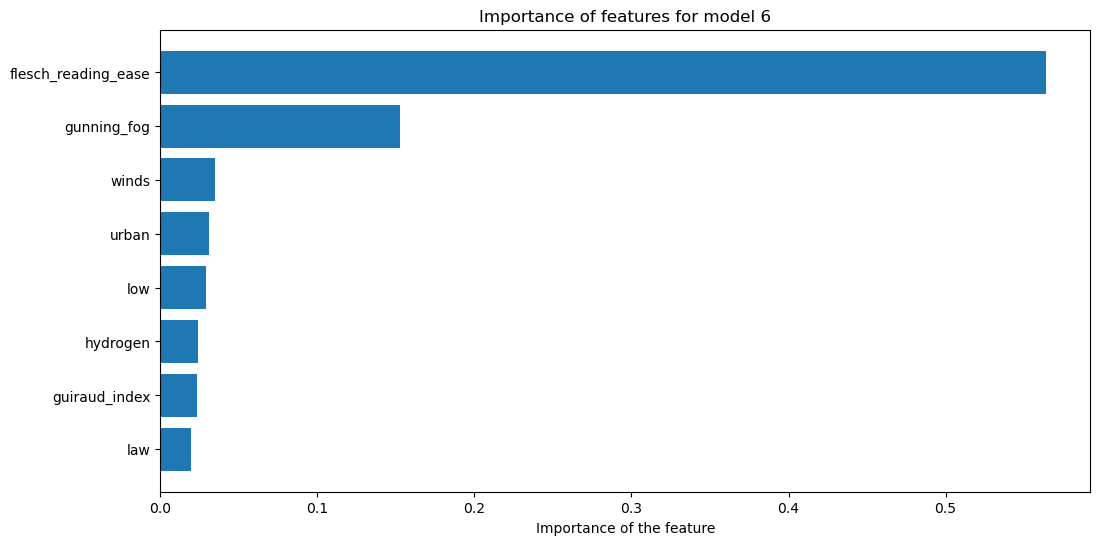

Category 6 - QWK scores for each fold: [0.73155622 0.73329301 0.72496129 0.6952381  0.76800682]
Category 6 - Average QWK: 0.730611089667575
Category 6 - Standard Deviation of QWK: 0.023193516071512987


<Figure size 640x480 with 0 Axes>

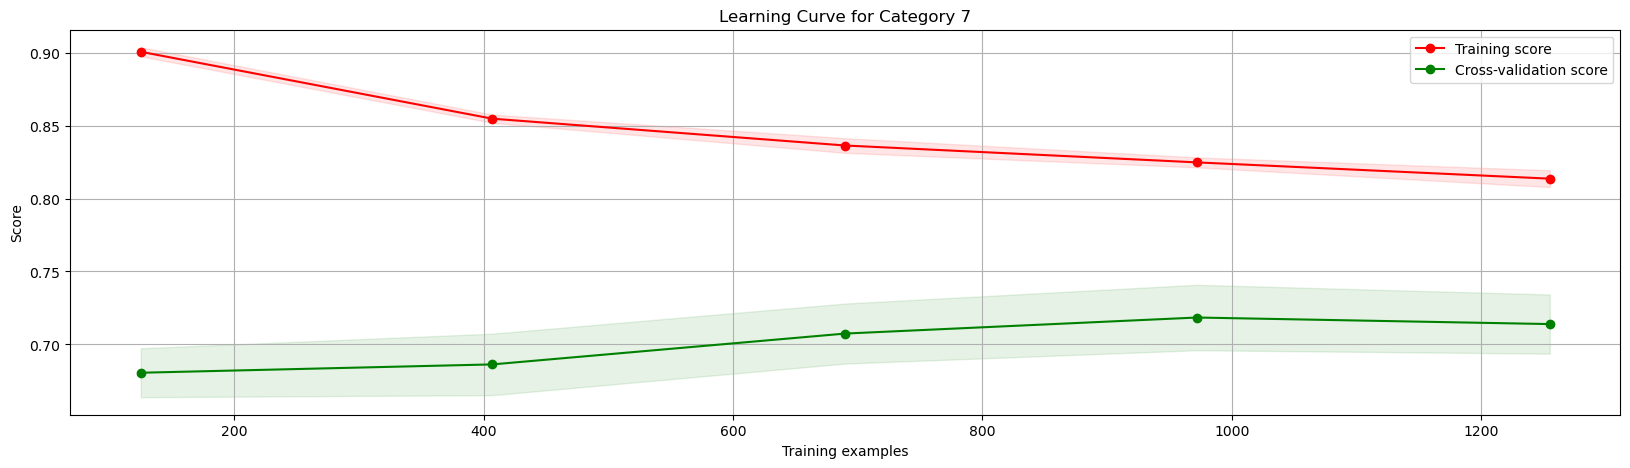

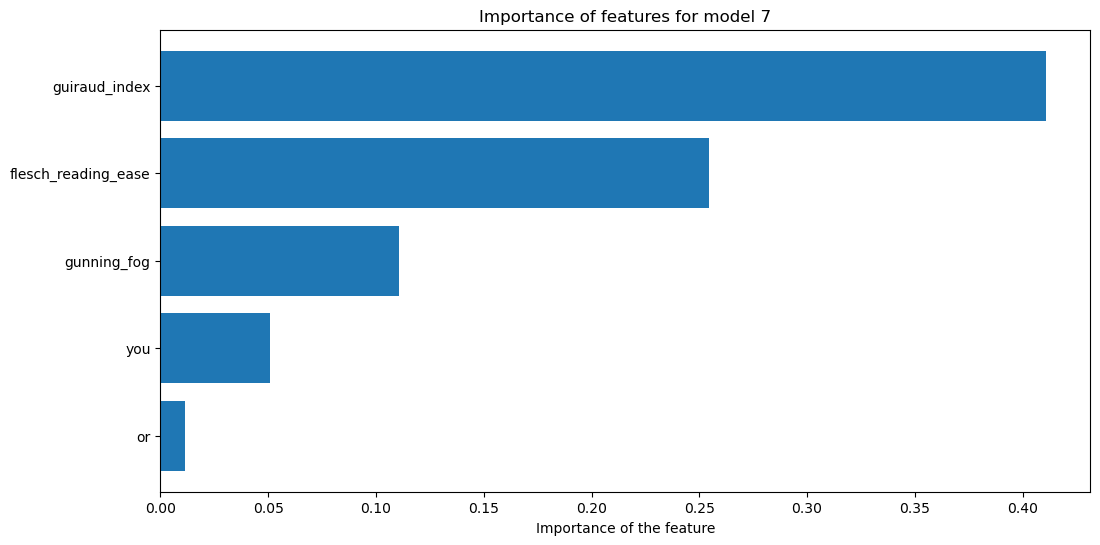

Category 7 - QWK scores for each fold: [0.69123681 0.68827157 0.72300117 0.73751926 0.72483188]
Category 7 - Average QWK: 0.7129721378250176
Category 7 - Standard Deviation of QWK: 0.019628238308710487


<Figure size 640x480 with 0 Axes>

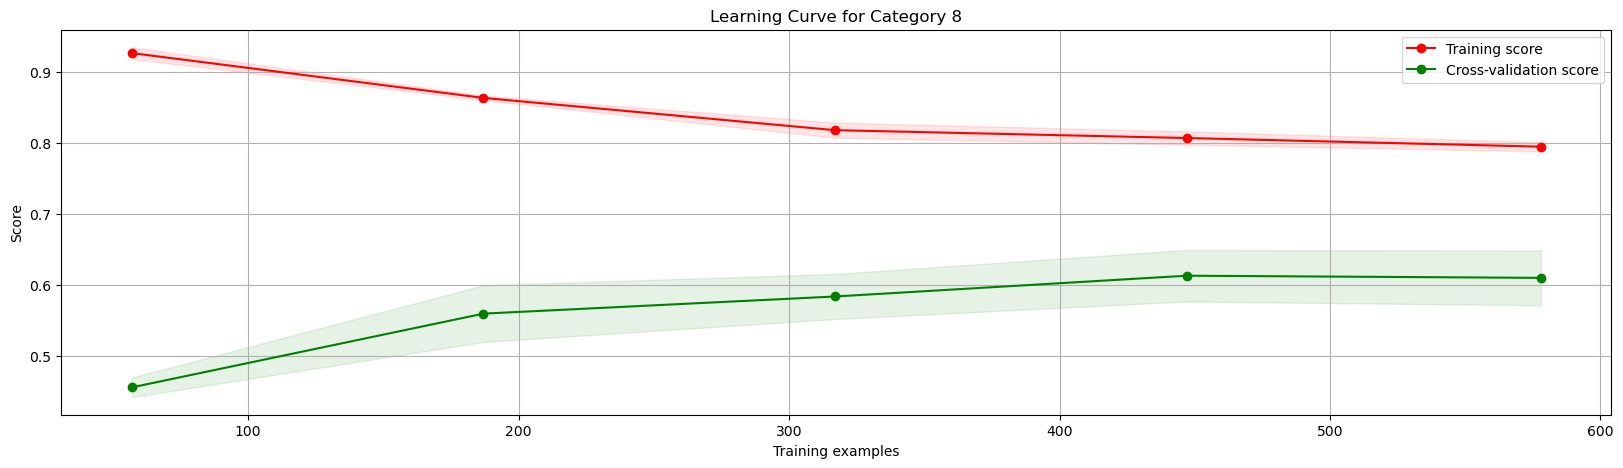

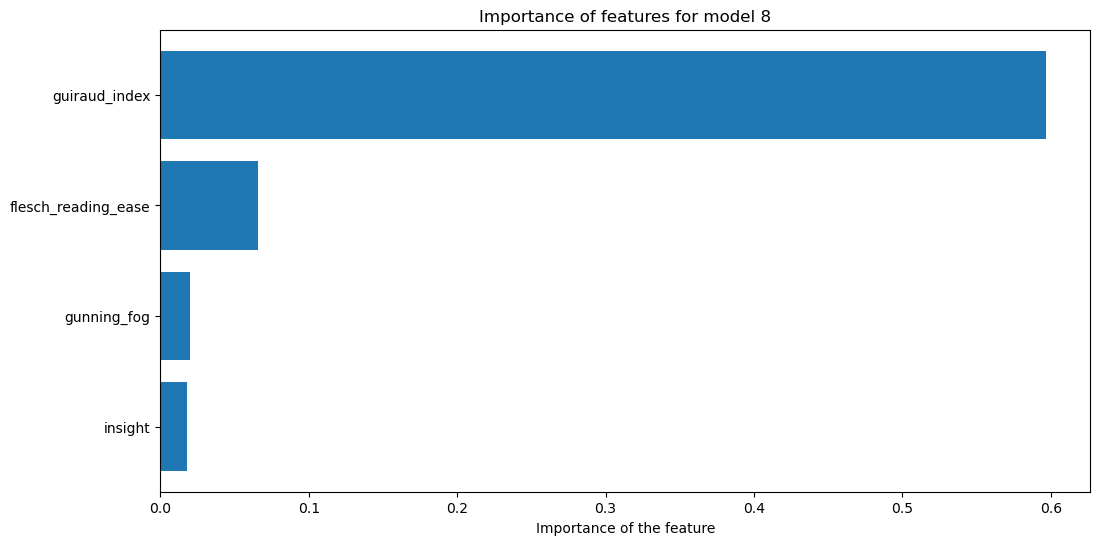

Category 8 - QWK scores for each fold: [0.56925273 0.55936211 0.62869814 0.66179921 0.62802381]
Category 8 - Average QWK: 0.6094272004065215
Category 8 - Standard Deviation of QWK: 0.03893721163865753


In [16]:
# Create a QWK scorer to use in cross-validation
qwk_scorer = make_scorer(qwk)

# Initialize dictionaries to store models and cross-validation results for QWK
models = {}
cross_validation_results_qwk = {}
feature_importances_dict = {}

# Loop through each essay category to train separate models and generate learning curves
for cat in [1, 2, 3, 4, 5, 6, 7, 8]:
    # Select data for the current category
    category_data = train_df_no_nans[train_df_no_nans['essay_set'] == cat]
    
    # Configure the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2), strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}')
    
    # Apply TF-IDF vectorization to cleaned essay texts
    train_vectors_tfidf = tfidf_vectorizer.fit_transform(category_data['cleaned_essay'])
    
    # Extract additional features relevant to essay evaluation
    additional_metrics = category_data[['ttr', 'guiraud_index', 'sentiment_polarity',
            'flesch_reading_ease', 'gunning_fog']]
    additional_features_sparse = scipy.sparse.csr_matrix(additional_metrics.values)
    X_combined = hstack([train_vectors_tfidf, additional_features_sparse])  # Combine TF-IDF features with additional metrics
    
    y = category_data['domain1_score']  # Target variable: essay scores
    
    # Initialize the RandomForestRegressor model
    model = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)
    
    # Perform cross-validation for QWK
    cross_val_scores_qwk = cross_val_score(model, X_combined, y, cv=5, scoring=qwk_scorer)
    qwk_scores = cross_val_scores_qwk
    cross_validation_results_qwk[cat] = qwk_scores
    
    # Plot learning curve for the current category
    plt.figure()
    plot_learning_curve(model, f'Learning Curve for Category {cat}', X_combined, y, cv=5, n_jobs=-1)
    plt.show()

    # Fit the model to the combined dataset and store it
    model.fit(X_combined, y)
    models[cat] = model

    # Extract and store feature importances
    feature_importances = model.feature_importances_
    feature_importances_dict[cat] = feature_importances

    # Combine names of TF-IDF features and additional metrics for importance visualization
    feature_names = tfidf_vectorizer.get_feature_names_out().tolist() + list(additional_metrics.columns)
    
    # Sort features by importance and apply a threshold for visualization
    sorted_idx = np.argsort(feature_importances)[::-1]
    threshold = 0.01
    sorted_idx_threshold = sorted_idx[feature_importances[sorted_idx] > threshold]
    
    # Visualize the most important features for each category model
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx_threshold)), feature_importances[sorted_idx_threshold], align='center')
    plt.yticks(range(len(sorted_idx_threshold)), np.array(feature_names)[sorted_idx_threshold])
    plt.xlabel('Importance of the feature')
    plt.title(f'Importance of features for model {cat}')
    plt.gca().invert_yaxis()
    plt.show()
    
    # QWK scores for model evaluation
    print(f'Category {cat} - QWK scores for each fold: {qwk_scores}')
    print(f'Category {cat} - Average QWK: {np.mean(qwk_scores)}')
    print(f'Category {cat} - Standard Deviation of QWK: {np.std(qwk_scores)}')

## Model Insights

### Quadratic Weighted Kappa (QWK) Scores
The QWK scores indicate a high degree of agreement between the model's predictions and the human scores, with an average QWK of 0.81 for Category 1, 0.64 for Category 2, 0.73 for Category 6, and 0.61 for Category 8. These scores reflect the model's strong predictive power, although some variability suggests room for further optimization, especially in Category 8.

### Learning Curves
The learning curves for Categories 2, 6, and 8 show the model's performance over training data size. For Category 8, the learning curve suggests a higher variance, as the gap between training and validation scores is larger.

### Feature Importance
The feature importance plots reveal that `flesch_reading_ease` is a significant predictor for Categories 1 and 2, whereas `gunning_fog` and `guiraud_index` show varied importance across categories. Interestingly, Category 6 highlights unique features like `winds` and `urban`, suggesting topic-specific language features contribute significantly to the model's predictions.
